In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin
from kdelearn.metrics import pi_kf

from matplotlib import cm

In [3]:
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"  # computer modern (latex default style)
matplotlib.rcParams["font.family"] = "STIXGeneral"

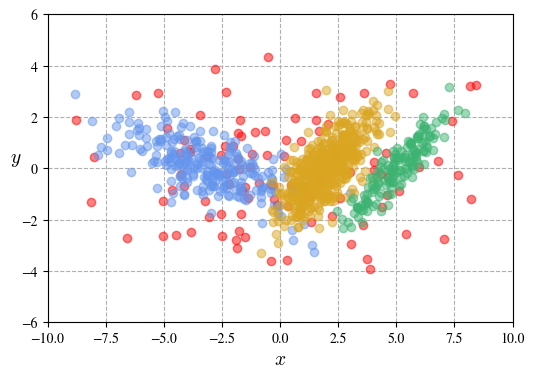

In [4]:
np.random.seed(1)

# Data
n_experiments = 1
m_train = 1000
n_x, n_y = 1, 1

# Class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
# Class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
# Class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
# Class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]

z_train = np.empty((n_experiments, m_train, n_x + n_y))
labels_train1 = np.full(m_train1, 1, dtype=np.int32)
labels_train2 = np.full(m_train2, 2, dtype=np.int32)
labels_train3 = np.full(m_train3, 3, dtype=np.int32)
labels_train4 = np.full(m_train4, 4, dtype=np.int32)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

for e in range(n_experiments):
    # Class 1
    z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
    # Class 2
    z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
    # Class 3
    z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
    # Class 4
    z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)

    z_train[e, :, :] = np.concatenate((z_train1, z_train2, z_train3, z_train4), axis=0)

x_train = z_train[:, :, [0]]
y_train = z_train[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[0, -m_train4:], y_train[0, -m_train4:], c="red", zorder=2, alpha=0.5)
plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], c="cornflowerblue", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], c="goldenrod", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], c="mediumseagreen", zorder=2, alpha=0.5)

plt.xlim(-10, 10)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(linestyle="--")
# plt.savefig("synthetic_data.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [5]:
bandwidth_z = np.zeros((n_experiments, n_x + n_y))
for e in range(n_experiments):
    bandwidth_z[e] = direct_plugin(z_train[e])
bandwidth_x = bandwidth_z[:, :n_x]
bandwidth_y = bandwidth_z[:, n_x:]

x_grid = np.linspace(-10, 10, 1000)[:, None]

\newpage

# $y^*=0$

In [6]:
y_star = np.array([0.0] * n_y)

## 1 wariant wskaźnika jakości

Wskaźnik taki sam jak w ujęciu bezwarunkowym:

$$PI_{KF} = \frac{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{out} | y^*)}{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{in} | y^*)}$$

W liczniku biorą udział wszystkie elementy nietypowe, natomiast w mianowniku tylko $m_{out}$ elementów typowych o najmniejszych wartościach estymatora gęstości.

### Wynik podstawowy dla r=0.05

Wskaźnik jakości (PI_kf): 0.416732
Liczba elementów nietypowych: 130/1000 (13.0%)


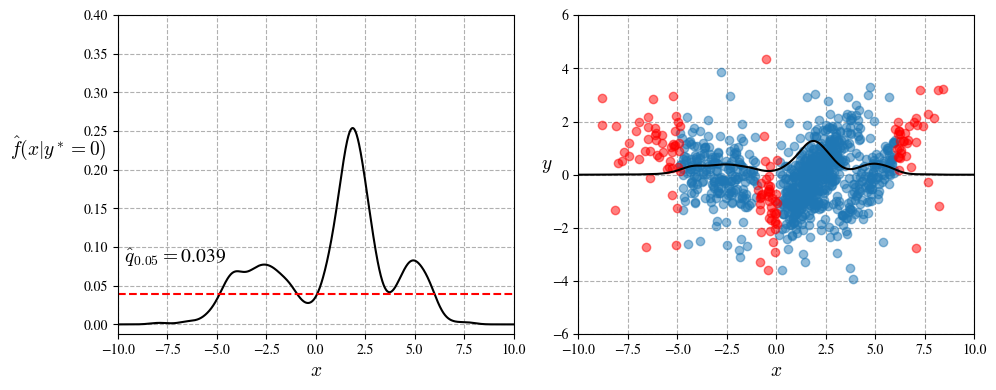

In [7]:
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0],
                                                    bandwidth_y=bandwidth_y[0],
                                                    r=0.05)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train[0])

inliers = labels_pred == 0
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()

scores_train = ckde_outlier_detector.ckde.pdf(x_train[0])
scores_out = scores_train[outliers]
scores_in = np.sort(scores_train[inliers])[:n_outliers]
metric = np.sum(scores_out) / np.sum(scores_in)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")
print(f"Liczba elementów nietypowych: {n_outliers}/{m_train} ({100 * n_outliers/m_train}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red")
axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

### Wynik optymalny po przeszukiwaniu siatki

In [8]:
# h_mul_grid = (1.0, 0.75, 1.25, 0.5, 1.5)
# r_grid = (0.01, 0.05, 0.1, 0.15, 0.2)

h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)
r_grid = (0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3)


print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")
print(f"Siatka dla r: {r_grid}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
Siatka dla r: (0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3)


Najlepszy mnożnik h_x: 0.50, h_y: 0.50
Najlepsze r: 0.001
Przy wskaźniku jakości: 0.115622
Liczba elementów nietypowych: 29/1000 (2.9%)


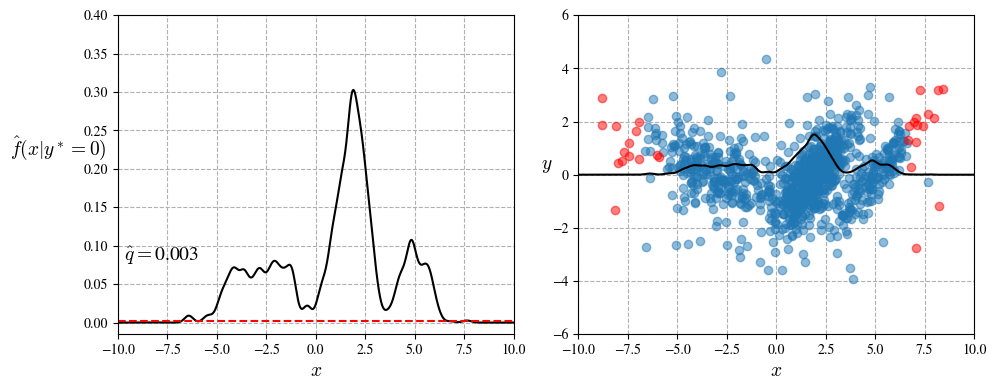

In [9]:
best_metric = np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        for r in r_grid:

            ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                                bandwidth_x=bandwidth_x[0] * h_mul_x,
                                                                bandwidth_y=bandwidth_y[0] * h_mul_y,
                                                                r=r)
            labels_pred = ckde_outlier_detector.predict(x_train[0])

            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()

            scores_train = ckde_outlier_detector.ckde.pdf(x_train[0])
            scores_out = scores_train[outliers]
            scores_in = np.sort(scores_train[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
            
            if metric < best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_r = r
                best_metric = metric

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Najlepsze r: {best_r:.3f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")


##
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0] * best_h_mul_x,
                                                    bandwidth_y=bandwidth_y[0] * best_h_mul_y,
                                                    r=best_r)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train[0])
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{m_train} ({100 * n_outliers/m_train}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red")
axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

\newpage

## 2 wariant wskaźnika jakości

Wskaźnik uzupełniony o wektor $d$:

$$PI_{KF} = \frac{\sum_{i=1}^{m_{out}} d_i^{out} \hat{f}(x_i^{out} | y^*)}{\sum_{i=1}^{m_{out}} d_i^{in} \hat{f}(x_i^{in} | y^*)}$$

W liczniku biorą udział wszystkie elementy nietypowe, natomiast w mianowniku tylko $m_{out}$ elementów typowych o najmniejszych wartościach estymatora gęstości.

### Wynik podstawowy dla r=0.05

Wskaźnik jakości (PI_kf): 0.199395
Liczba elementów nietypowych: 130/1000 (13.0%)


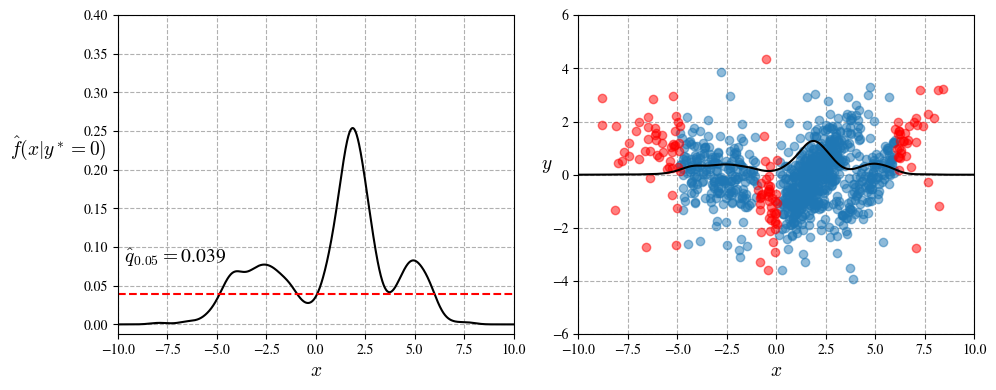

In [10]:
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0],
                                                    bandwidth_y=bandwidth_y[0],
                                                    r=0.05)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train[0])

inliers = labels_pred == 0
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()

scores_train = ckde_outlier_detector.ckde.pdf(x_train[0])
scores_out = scores_train[outliers]
d_out = ckde_outlier_detector.ckde.c_weights_train[outliers]

a = np.argsort(scores_train[inliers])
scores_in = scores_train[inliers][a][:n_outliers]
d_in = ckde_outlier_detector.ckde.c_weights_train[inliers][a][:n_outliers]

metric = np.sum(d_out * scores_out) / np.sum(d_in * scores_in)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")
print(f"Liczba elementów nietypowych: {n_outliers}/{m_train} ({100 * n_outliers/m_train}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red")
axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

### Wynik optymalny po przeszukiwaniu siatki

Najlepszy mnożnik h_x: 2.00, h_y: 0.90
Najlepsze r: 0.001
Przy wskaźniku jakości: 0.000003
Liczba elementów nietypowych: 5/1000 (0.5%)


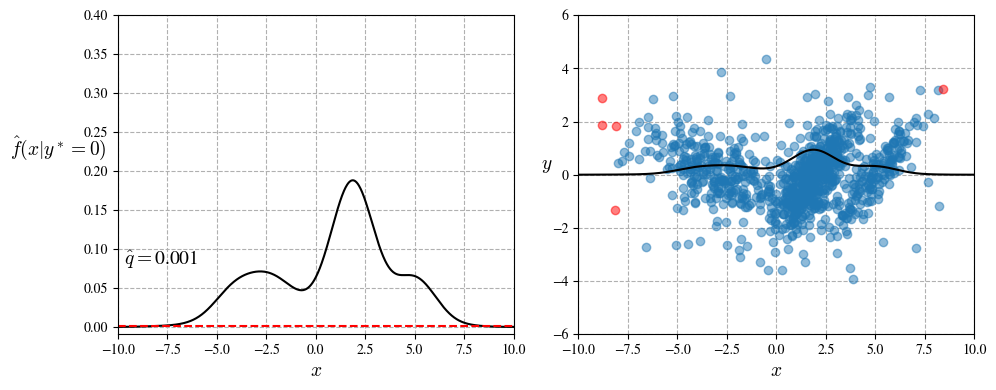

In [11]:
best_metric = np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        for r in r_grid:

            ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                                bandwidth_x=bandwidth_x[0] * h_mul_x,
                                                                bandwidth_y=bandwidth_y[0] * h_mul_y,
                                                                r=r)
            labels_pred = ckde_outlier_detector.predict(x_train[0])

            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()

            scores_train = ckde_outlier_detector.ckde.pdf(x_train[0])
            scores_out = scores_train[outliers]
            d_out = ckde_outlier_detector.ckde.c_weights_train[outliers]
            a = np.argsort(scores_train[inliers])
            scores_in = scores_train[inliers][a][:n_outliers]
            d_in = ckde_outlier_detector.ckde.c_weights_train[inliers][a][:n_outliers]
            metric = np.sum(d_out * scores_out) / np.sum(d_in * scores_in)
            
            if metric < best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_r = r
                best_metric = metric

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Najlepsze r: {best_r:.3f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")


##
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0] * best_h_mul_x,
                                                    bandwidth_y=bandwidth_y[0] * best_h_mul_y,
                                                    r=best_r)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train[0])
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{m_train} ({100 * n_outliers/m_train}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q}= $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red")
axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

\newpage

## 2' wariant wskaźnika jakości

$$PI_{KF} = \frac{
\left[ \sum_{i=1}^{m_{out}} d_i^{in} \right] \left[ \sum_{i=1}^{m_{out}} d_i^{out} \hat{f}(x_i^{out} | y^*) \right]
}
{
\left[ \sum_{i=1}^{m_{out}} d_i^{out} \right] \left[ \sum_{i=1}^{m_{out}} d_i^{in} \hat{f}(x_i^{in} | y^*) \right]
}$$

### Wynik podstawowy dla r=0.05

Wskaźnik jakości (PI_kf): 0.000013
Liczba elementów nietypowych: 130/1000 (13.0%)


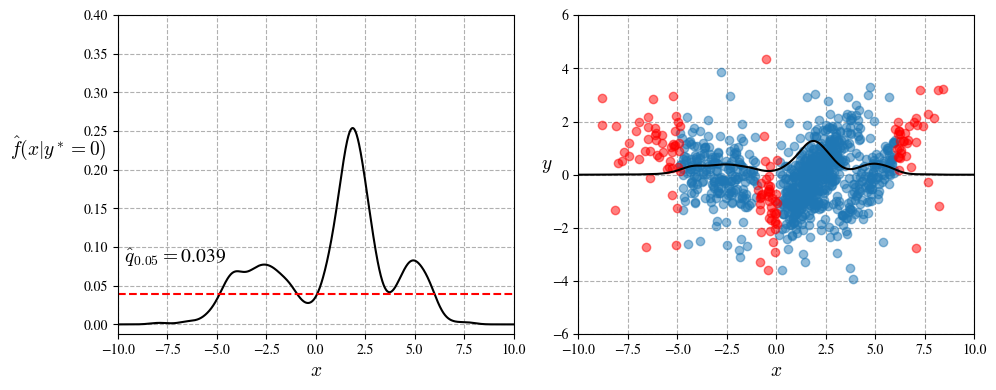

In [12]:
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0],
                                                    bandwidth_y=bandwidth_y[0],
                                                    r=0.05)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train[0])

inliers = labels_pred == 0
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()

scores_train = ckde_outlier_detector.ckde.pdf(x_train[0])
scores_out = scores_train[outliers]
d_out = ckde_outlier_detector.ckde.c_weights_train[outliers]

a = np.argsort(scores_train[inliers])
scores_in = scores_train[inliers][a][:n_outliers]
d_in = ckde_outlier_detector.ckde.c_weights_train[inliers][a][:n_outliers]

metric = np.sum(d_in) * np.sum(d_out * scores_out) / np.sum(d_out) * np.sum(d_in * scores_in)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")
print(f"Liczba elementów nietypowych: {n_outliers}/{m_train} ({100 * n_outliers/m_train}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red")
axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

### Wynik optymalny po przeszukiwaniu siatki

Najlepszy mnożnik h_x: 1.40, h_y: 0.80
Najlepsze r: 0.001
Przy wskaźniku jakości: 0.000000
Liczba elementów nietypowych: 6/1000 (0.6%)


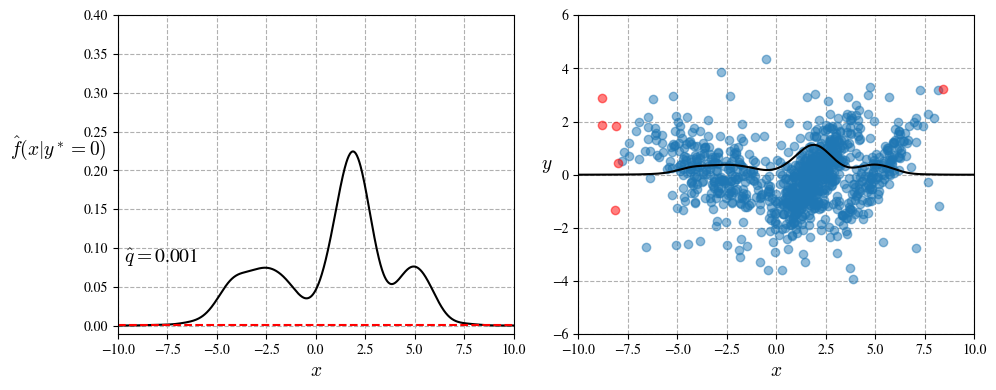

In [13]:
best_metric = np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        for r in r_grid:

            ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                                bandwidth_x=bandwidth_x[0] * h_mul_x,
                                                                bandwidth_y=bandwidth_y[0] * h_mul_y,
                                                                r=r)
            labels_pred = ckde_outlier_detector.predict(x_train[0])

            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            
            scores_train = ckde_outlier_detector.ckde.pdf(x_train[0])
            scores_out = scores_train[outliers]
            d_out = ckde_outlier_detector.ckde.c_weights_train[outliers]
            a = np.argsort(scores_train[inliers])
            scores_in = scores_train[inliers][a][:n_outliers]
            d_in = ckde_outlier_detector.ckde.c_weights_train[inliers][a][:n_outliers]
            metric = np.sum(d_in) * np.sum(d_out * scores_out) / np.sum(d_out) * np.sum(d_in * scores_in)
            
#             metric = pi_kf(x_train[0], labels_pred, ckde_outlier_detector.ckde.c_weights_train)

            if metric < best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_r = r
                best_metric = metric

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Najlepsze r: {best_r:.3f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")


##
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0] * best_h_mul_x,
                                                    bandwidth_y=bandwidth_y[0] * best_h_mul_y,
                                                    r=best_r)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train[0])
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{m_train} ({100 * n_outliers/m_train}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q}= $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.5, c="red")
axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

\newpage

## Eksperyment 3 - analiza sąsiedztwie $y^*$

Wskaźnik taki sam jak w ujęciu bezwarunkowym:

$$PI_{KF} = \frac{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{out} | y^*)}{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{in} | y^*)}$$

### Wynik podstawowy dla r=0.05

In [14]:
cond = (y_train[0, :, 0] > y_star[0]-0.5) & (y_train[0, :, 0] < y_star[0]+0.5)

x_train_tmp = x_train[0, cond]
y_train_tmp = y_train[0, cond]

Wskaźnik jakości (PI_kf): 0.481242
Liczba elementów nietypowych: 16/360 (4.444%)


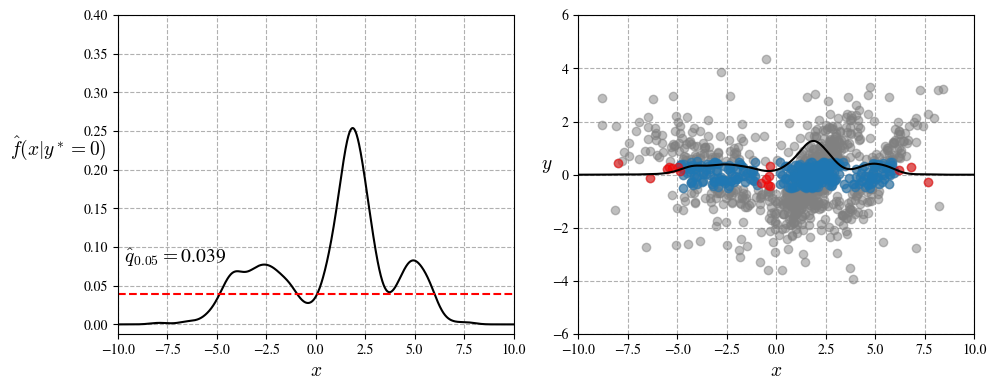

In [15]:
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0],
                                                    bandwidth_y=bandwidth_y[0],
                                                    r=0.05)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train_tmp)

inliers = labels_pred == 0
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()

scores_train = ckde_outlier_detector.ckde.pdf(x_train_tmp)
scores_out = scores_train[outliers]
scores_in = np.sort(scores_train[inliers])[:n_outliers]
metric = np.sum(scores_out) / np.sum(scores_in)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")
print(f"Liczba elementów nietypowych: {n_outliers}/{x_train_tmp.shape[0]} ({100 * n_outliers/x_train_tmp.shape[0]:.3f}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0], y_train[0], zorder=2, alpha=0.5, c="gray")
axs[1].scatter(x_train_tmp[labels_pred==0], y_train_tmp[labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train_tmp[labels_pred==1], y_train_tmp[labels_pred==1], zorder=2, alpha=0.5, c="red")

axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

### Wynik optymalny po przeszukiwaniu siatki

/tmp/ipykernel_9311/858684512.py:19: RuntimeWarning: invalid value encountered in scalar divide
  metric = np.sum(scores_out) / np.sum(scores_in)


Najlepszy mnożnik h_x: 0.90, h_y: 0.50
Najlepsze r: 0.001
Przy wskaźniku jakości: 0.061025
Liczba elementów nietypowych: 1/360 (0.278%)


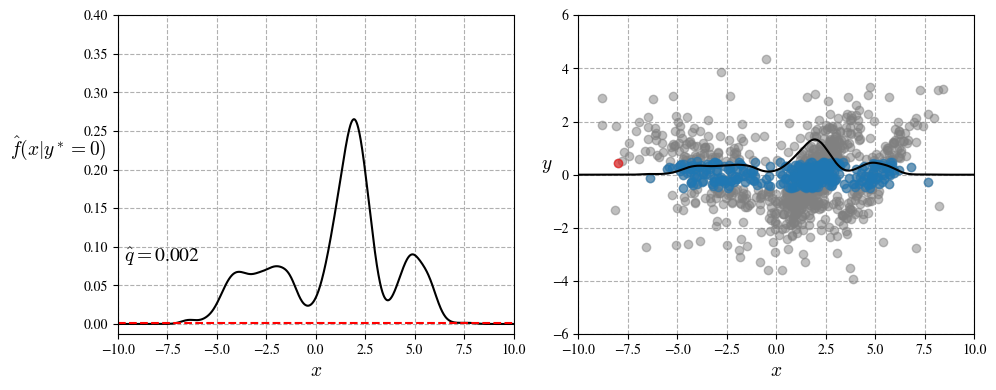

In [16]:
best_metric = np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        for r in r_grid:

            ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                                bandwidth_x=bandwidth_x[0] * h_mul_x,
                                                                bandwidth_y=bandwidth_y[0] * h_mul_y,
                                                                r=r)
            labels_pred = ckde_outlier_detector.predict(x_train_tmp)

            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()

            scores_train = ckde_outlier_detector.ckde.pdf(x_train_tmp)
            scores_out = scores_train[outliers]
            scores_in = np.sort(scores_train[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
            
            if metric < best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_r = r
                best_metric = metric

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Najlepsze r: {best_r:.3f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

##
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0] * best_h_mul_x,
                                                    bandwidth_y=bandwidth_y[0] * best_h_mul_y,
                                                    r=best_r)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train_tmp)
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{x_train_tmp.shape[0]} ({100 * n_outliers/x_train_tmp.shape[0]:.3f}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0], y_train[0], zorder=2, alpha=0.5, c="gray")
axs[1].scatter(x_train_tmp[labels_pred==0], y_train_tmp[labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train_tmp[labels_pred==1], y_train_tmp[labels_pred==1], zorder=2, alpha=0.5, c="red")

axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

\newpage

## Eksperyment 3' - analiza sąsiedztwie $y^*$

$$PI_{KF} = \frac{
\left[ \sum_{i=1}^{m_{out}} d_i^{in} \right] \left[ \sum_{i=1}^{m_{out}} d_i^{out} \hat{f}(x_i^{out} | y^*) \right]
}
{
\left[ \sum_{i=1}^{m_{out}} d_i^{out} \right] \left[ \sum_{i=1}^{m_{out}} d_i^{in} \hat{f}(x_i^{in} | y^*) \right]
}$$

### Wynik podstawowy dla r=0.05

In [17]:
cond = (y_train[0, :, 0] > y_star[0]-0.5) & (y_train[0, :, 0] < y_star[0]+0.5)

x_train_tmp = x_train[0, cond]
y_train_tmp = y_train[0, cond]

Wskaźnik jakości (PI_kf): 0.000001
Liczba elementów nietypowych: 16/360 (4.444%)


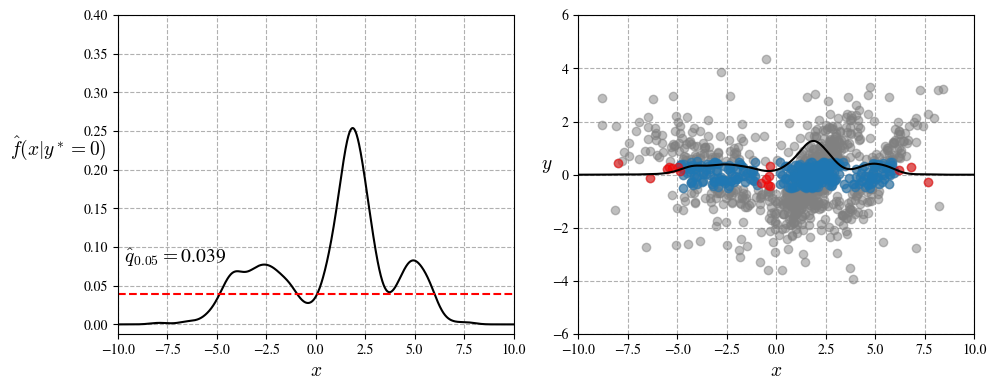

In [18]:
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0],
                                                    bandwidth_y=bandwidth_y[0],
                                                    r=0.05)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train_tmp)

inliers = labels_pred == 0
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()

scores_train = ckde_outlier_detector.ckde.pdf(x_train_tmp)
scores_out = scores_train[outliers]
d_out = ckde_outlier_detector.ckde.c_weights_train[cond][outliers]

a = np.argsort(scores_train[inliers])
scores_in = scores_train[inliers][a][:n_outliers]
d_in = ckde_outlier_detector.ckde.c_weights_train[cond][inliers][a][:n_outliers]

metric = np.sum(d_in) * np.sum(d_out * scores_out) / np.sum(d_out) * np.sum(d_in * scores_in)

print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")
print(f"Liczba elementów nietypowych: {n_outliers}/{x_train_tmp.shape[0]} ({100 * n_outliers/x_train_tmp.shape[0]:.3f}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q}_{0.05} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0], y_train[0], zorder=2, alpha=0.5, c="gray")
axs[1].scatter(x_train_tmp[labels_pred==0], y_train_tmp[labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train_tmp[labels_pred==1], y_train_tmp[labels_pred==1], zorder=2, alpha=0.5, c="red")

axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

### Wynik optymalny po przeszukiwaniu siatki

/tmp/ipykernel_9311/109503357.py:24: RuntimeWarning: invalid value encountered in scalar divide
  metric = np.sum(d_in) * np.sum(d_out * scores_out) / np.sum(d_out) * np.sum(d_in * scores_in)


Najlepszy mnożnik h_x: 1.00, h_y: 0.50
Najlepsze r: 0.001
Przy wskaźniku jakości: 0.000000
Liczba elementów nietypowych: 1/360 (0.278%)


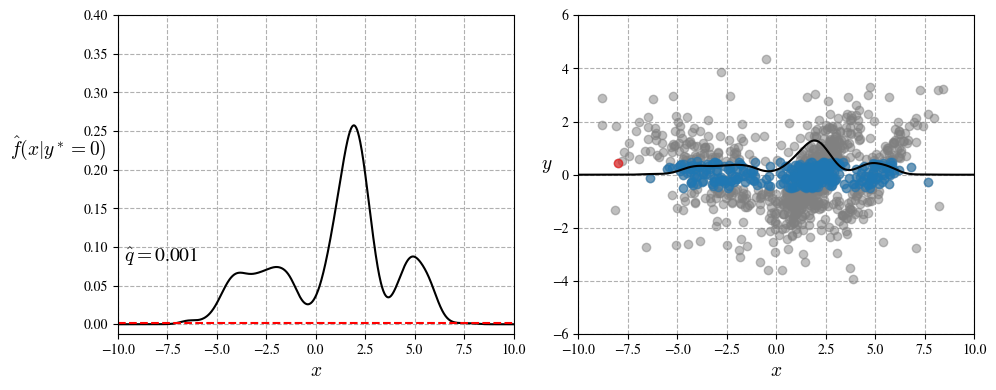

In [19]:
best_metric = np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        for r in r_grid:

            ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                                bandwidth_x=bandwidth_x[0] * h_mul_x,
                                                                bandwidth_y=bandwidth_y[0] * h_mul_y,
                                                                r=r)
            labels_pred = ckde_outlier_detector.predict(x_train_tmp)

            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            
            scores_train = ckde_outlier_detector.ckde.pdf(x_train_tmp)
            scores_out = scores_train[outliers]
            d_out = ckde_outlier_detector.ckde.c_weights_train[cond][outliers]

            a = np.argsort(scores_train[inliers])
            scores_in = scores_train[inliers][a][:n_outliers]
            d_in = ckde_outlier_detector.ckde.c_weights_train[cond][inliers][a][:n_outliers]

            metric = np.sum(d_in) * np.sum(d_out * scores_out) / np.sum(d_out) * np.sum(d_in * scores_in)

            if metric < best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_r = r
                best_metric = metric

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Najlepsze r: {best_r:.3f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

##
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0] * best_h_mul_x,
                                                    bandwidth_y=bandwidth_y[0] * best_h_mul_y,
                                                    r=best_r)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train_tmp)
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{x_train_tmp.shape[0]} ({100 * n_outliers/x_train_tmp.shape[0]:.3f}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0], y_train[0], zorder=2, alpha=0.5, c="gray")
axs[1].scatter(x_train_tmp[labels_pred==0], y_train_tmp[labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train_tmp[labels_pred==1], y_train_tmp[labels_pred==1], zorder=2, alpha=0.5, c="red")

axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
# axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()